In [16]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib 
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import BatchNormalization, Concatenate,concatenate
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sn

## Iperparametri

In [17]:
use_layer_regression = False
learning_rate = 0.001
logIndex = 19
input_dropout_rate = 0.3
dropout_rate = 0.5

hidden_layers = [200, 100]
n_output = 7

batch_size = 20
epochs = 150

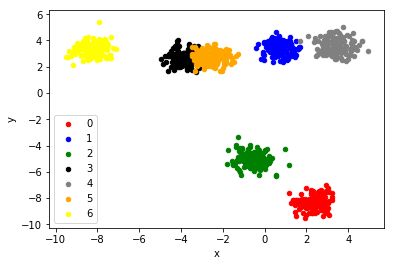

In [18]:
from sklearn.datasets.samples_generator import make_blobs
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=7, n_features=100, cluster_std=0.5)
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green', 3:'black', 4:'gray', 5:'orange', 6:'yellow', 7:'purple'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

## Preelabora i dati

In [19]:
df = pd.read_csv('patterns.csv')
all = df.iloc[:, :].values.astype(np.float32)
A = all[all[:,-1]<70]
B = all[(all[:,-1]>=70)&(all[:,-1]<=83)]
C = all[(all[:,-1]>=84)&(all[:,-1]<=98)] 
D = all[(all[:,-1]>=99)&(all[:,-1]<=113)] 
E = all[(all[:,-1]>=114)&(all[:,-1]<=128)] 
F = all[(all[:,-1]>=129)&(all[:,-1]<=143)] 
G = all[all[:,-1]>143]

#prende solo una parte dei dati della categoria A
A = A[0:330,:]

#crea nuovamente il dataframe dopo aver pre-elaborato i dati
data = np.concatenate((A,B,C,D,E,F,G), axis=0)
np.random.shuffle(data)
df = pd.DataFrame(data=data)

## Ottiene i dati

In [20]:
#df = pd.read_csv('patterns.csv')
#print(df.head(5))

#ottiene gli input ed li divide in dummy variables
X1 = pd.get_dummies(df.iloc[:, 0]).values.astype(np.float32)
X2 = pd.get_dummies(df.iloc[:, 24]).values.astype(np.float32)
for i in range(1,24):
    X1_dummy = pd.get_dummies(df.iloc[:, i]).values.astype(np.float32)
    X2_dummy = pd.get_dummies(df.iloc[:, i+24]).values.astype(np.float32)
    X1 = np.concatenate((X1, X1_dummy), axis=1)
    X2 = np.concatenate((X2, X2_dummy), axis=1)

#ottiene gli output e li trasforma in classi    
y = df.iloc[:, -1].values.astype(np.float32)
yc = []
for i in range(len(y)):
    yi = np.zeros(7)
    if (y[i]<70):                 yi[0] = 1 #A
    if (y[i]>=70  and y[i]<=83) : yi[1] = 1 #B
    if (y[i]>=84  and y[i]<=98) : yi[2] = 1 #C
    if (y[i]>=99  and y[i]<=113): yi[3] = 1 #D
    if (y[i]>=114 and y[i]<=128): yi[4] = 1 #E
    if (y[i]>=129 and y[i]<=143): yi[5] = 1 #F
    if (y[i]>143):                yi[6] = 1 #G
    yc.append(yi)
y = np.array(yc)

#separa dati di train da dati di test
test_size=0.33
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, test_size=test_size, random_state=42)

X_train = np.concatenate((X1_train, X2_train), axis=1)
X_test = np.concatenate((X1_test, X2_test), axis=1)

## Crea il modello ed effettua il training

In [21]:
n_input = X1_train.shape[1]
input1 = Input((n_input,))
input2 = Input((n_input,))
layer = concatenate([input1, input2], axis=1)
layer = Dropout(input_dropout_rate)(layer)
layer = Activation('relu')(layer)
    
for i in range(len(hidden_layers)):
    #aggiunge lo strato nascosto
    #layer = BatchNormalization()(layer)
    layer = Dense(hidden_layers[i])(layer)
    layer = Dropout(dropout_rate)(layer)
    layer = Activation('relu')(layer)
    
#aggiunge lo strato di uscita
#layer = BatchNormalization()(layer)
layer = Dense(n_output)(layer)
layer = Dropout(dropout_rate)(layer)
output = Activation('softmax')(layer)

#crea il modello
model = Model([input1, input2], output)

#compila la rete neurale
optimizer = Adam(lr=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#addestra la rete neurale
history = model.fit([X1_train, X2_train], y_train, batch_size=batch_size, epochs=epochs, validation_data=([X1_test, X2_test], y_test), verbose=1)

Train on 995 samples, validate on 491 samples
Epoch 1/150
995/995 [==============================] - 0s 498us/step - loss: 0.4568 - acc: 0.8399 - val_loss: 0.3899 - val_acc: 0.8571
Epoch 2/150
995/995 [==============================] - 0s 144us/step - loss: 0.4097 - acc: 0.8507 - val_loss: 0.3821 - val_acc: 0.8571
Epoch 3/150
995/995 [==============================] - 0s 137us/step - loss: 0.4081 - acc: 0.8501 - val_loss: 0.3845 - val_acc: 0.8571
Epoch 4/150
995/995 [==============================] - 0s 149us/step - loss: 0.3954 - acc: 0.8544 - val_loss: 0.3790 - val_acc: 0.8571
Epoch 5/150
995/995 [==============================] - 0s 159us/step - loss: 0.3927 - acc: 0.8566 - val_loss: 0.3796 - val_acc: 0.8571
Epoch 6/150
995/995 [==============================] - 0s 141us/step - loss: 0.3885 - acc: 0.8563 - val_loss: 0.3778 - val_acc: 0.8571
Epoch 7/150
995/995 [==============================] - 0s 151us/step - loss: 0.3823 - acc: 0.8560 - val_loss: 0.3724 - val_acc: 0.8571
Epoch 8/1

## Stampa le perdite

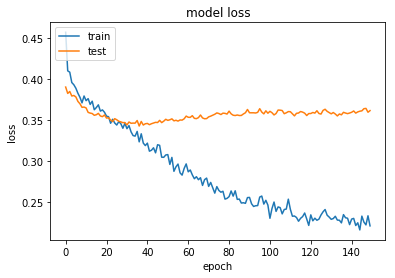

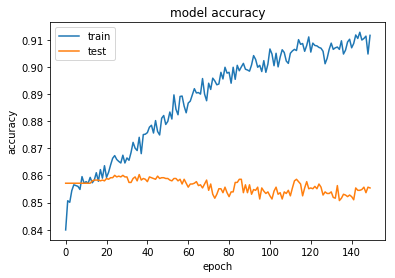

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Valuta il modello

In [23]:
#ottiene le predictions dal modello
res_prediction = model.predict([X1_test, X2_test])
labels = y_test

predictions = np.zeros_like(res_prediction)
for i in range(len(res_prediction)):
    predictions[i, np.argmax(res_prediction[i])] = 1

accuracy_score: 0.3585
precision_score: 0.3688
recall_score: 0.3585
f1_score: 0.3548


C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Utente\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


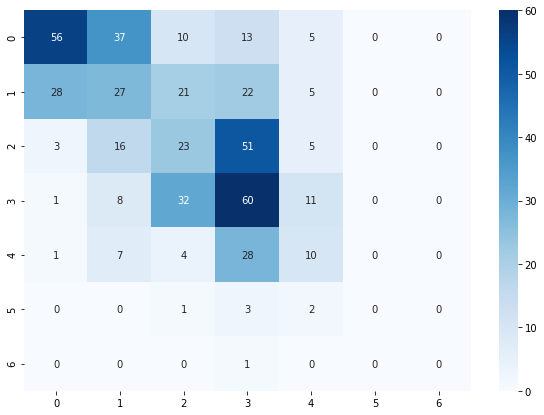

In [24]:
predictions_max = np.argmax(predictions, axis=1)
y_test_max = np.argmax(y_test, axis=1)

#calcola gli score
accuracy_score_val = accuracy_score(y_test_max, predictions_max)
precision_score_val = precision_score(y_test_max, predictions_max, average='weighted') # tp / (tp + fp)
recall_score_val = recall_score(y_test_max, predictions_max, average='weighted') # tp / (tp + fn)
f1_score_val = f1_score(y_test_max, predictions_max, average='weighted')

#stampa gli score
print("accuracy_score: %0.4f" % accuracy_score_val)
print("precision_score: %0.4f" % precision_score_val)
print("recall_score: %0.4f" % recall_score_val)
print("f1_score: %0.4f" % f1_score_val)

#ottiene e stampa la confusion matrix
categories = ('A','B','C','D','E','F','G')
cm = confusion_matrix(y_test_max, predictions_max)
df_cm = pd.DataFrame(cm, 
                     index = [i for i in range(cm.shape[1])],
                     columns = [i for i in range(cm.shape[1])])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')